# DS 5500 Assignment 4

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import re

In [45]:
math_data = pd.read_csv('./math-achievement-sch-sy2015-16.csv', low_memory=False)
arts_data = pd.read_csv('./rla-achievement-sch-sy2015-16.csv', low_memory=False)
fiscal_data = pd.read_csv('./Sdf16_1a.txt', sep='\t', low_memory=False)

## Problem 1

For the districts you selected for budget cuts in HW 3 Problem 4, calculate and visualize the proportion of each district’s total funding that will be lost.
Which districts will be affected by your budget cuts the most?

In [3]:
condition = fiscal_data['TFEDREV']>0
cut_amount = int((fiscal_data.loc[condition, 'TFEDREV'].sum())*0.15)
print('15% of the U.S. federal budget currently being spent on funding school districts:', cut_amount)

15% of the U.S. federal budget currently being spent on funding school districts: 8340411300


In [4]:
condition = (fiscal_data['TOTALREV']>0) & (fiscal_data['TOTALEXP']>0)
cut_rev = fiscal_data.assign(DEBT = fiscal_data['TOTALEXP'] - fiscal_data['TOTALREV']).query('DEBT<0')
cut_rev['LEAID'] = cut_rev['LEAID'].astype(str)
cut_rev['DEBT'] = -cut_rev['DEBT']
cut_rev = cut_rev.assign(AVAILABLE_CUT = cut_rev[['DEBT','TFEDREV']].min(axis=1))
available_amount = cut_rev['AVAILABLE_CUT'].sum()
cut_rev['CUT'] = (cut_amount/available_amount)*cut_rev['AVAILABLE_CUT']
cut_rev['CUT'] = round(cut_rev['CUT'])
cut_rev = cut_rev.query('CUT>0')
cut_rev['PROPORTION'] = cut_rev['CUT']/cut_rev['TFEDREV']

print('Ranking of school districts by cut in descending order:')
cut_rev = cut_rev.sort_values('CUT', ascending=False)
cut_rev[['LEAID','CUT','PROPORTION']]

Ranking of school districts by cut in descending order:


,LEAID,CUT,PROPORTION
1904,0622710,280561869.0,0.257066
3306,1500030,113901886.0,0.436187
15038,4218990,90139303.0,0.332165
9784,3200060,60848490.0,0.219173
3057,1201440,56389352.0,0.256337
6328,2400480,49165663.0,0.436187
6006,2201170,44611437.0,0.436187
7676,2680995,31849921.0,0.436187
5622,2012990,31376223.0,0.424164
3059,1201500,30676579.0,0.163717


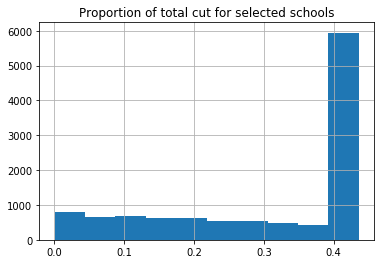

In [5]:
cut_rev['PROPORTION'].hist()
plt.title('Proportion of total cut for selected schools');

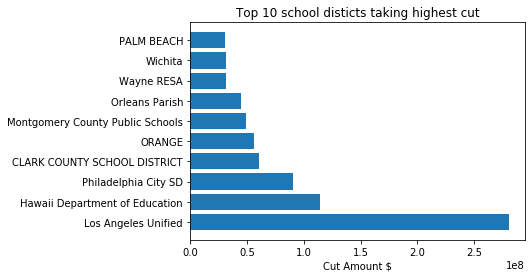

In [6]:
plt.barh(cut_rev['NAME'][0:10], cut_rev['CUT'][0:10])
plt.xlabel("Cut Amount $")
plt.title("Top 10 school disticts taking highest cut");

## Problem 2

A common problem with purely data-driven solutions is that they can inadvertently perpetuate hidden pre-existing biases in the data, and further disadvantage groups that are already disadvantaged.
Calculate the proportion of enrolled students by race for each district, then visualize the distributions of these for districts that received budget cuts versus districts that did not receive budget cuts.
Comment on whether the the distributions appear to be the same or different. Did your selection include any hidden biases, or manage to avoid them?

In [47]:
demographics = pd.read_csv('./ccd_lea_052_1516_w_1a_011717.csv', low_memory=False)
demographics = demographics.query('TOTAL>=0')
demographics = demographics.rename(columns={'AM':'American Indian/Alaska Native','AS':'Asian','HI':'Hispanic', 'BL':'Black',
                            'WH':'White','HP':'Hawaiian Native / Pacific Islander', 'TR':'Two or More Races'})

In [8]:
demographics = (
    demographics[['American Indian/Alaska Native','Asian','Hispanic','Black','White','Hawaiian Native / Pacific Islander','Two or More Races']]
    .div(demographics.TOTAL, axis=0)
    .assign(LEAID = demographics['LEAID'])
)
demographics['LEAID'] = demographics['LEAID'].astype(str)

In [9]:
budg_cut = demographics[demographics['LEAID'].isin(cut_rev['LEAID'])].drop('LEAID', axis=1).mean().reset_index().rename(columns = {0:'Budget Cut'})
no_budg_cut = demographics[~demographics['LEAID'].isin(cut_rev['LEAID'])].drop('LEAID', axis=1).mean().reset_index().rename(columns = {0:'No Budget Cut'})
race_dist = pd.merge(budg_cut, no_budg_cut, on = 'index', how='inner').rename(columns={'index':'Race'})

In [10]:
race_dist

,Race,Budget Cut,No Budget Cut
0,American Indian/Alaska Native,0.021995,0.030712
1,Asian,0.018803,0.026263
2,Hispanic,0.122228,0.199912
3,Black,0.105066,0.142116
4,White,0.701833,0.566853
5,Hawaiian Native / Pacific Islander,0.001092,0.001833
6,Two or More Races,0.028778,0.032018


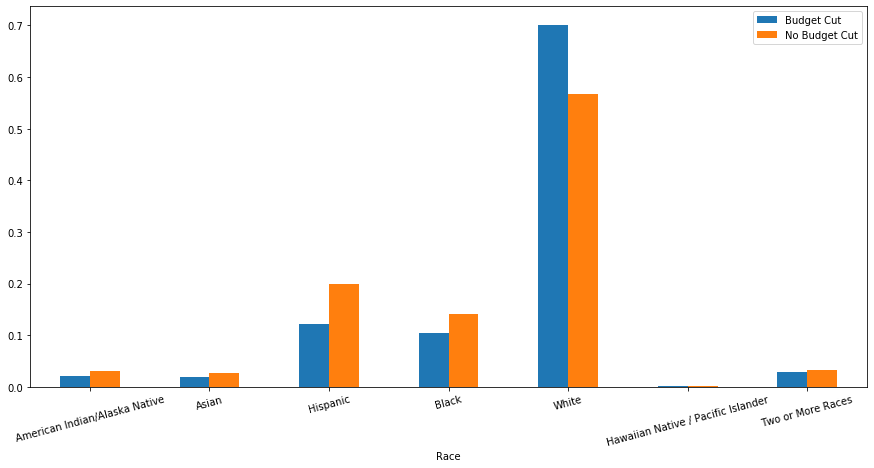

In [11]:
race_dist.plot(x="Race", y=["Budget Cut", "No Budget Cut"], kind="bar", figsize=(15,7))
plt.xticks(rotation=15);

The distributions do have differences. White students are 23% higher in proportion in the schools that were selected for budget cuts compared to the proportion in no budget cuts. Students of all the other races have an opposite trend. The model do have some biasess included.

## Problem 3

In [50]:
demographics = pd.read_csv('./ccd_lea_052_1516_w_1a_011717.csv', low_memory=False)
demographics['LEAID'] = demographics['LEAID'].astype(str)
disability = pd.read_csv('./ccd_lea_002089_1516_w_1a_011717.csv', low_memory=False)
disability['LEAID'] = disability['LEAID'].astype(str)

In [31]:
disability = pd.merge(disability, demographics[['LEAID', 'TOTAL']], on='LEAID', how='inner').query('TOTAL>0 and SPECED>0')
disability['Proportion'] = disability['SPECED']/disability['TOTAL']

In [14]:
disb_prop = pd.DataFrame(data={'Budget Cut': [None], 'No Budget Cut': [None]})

In [20]:
disb_prop.loc[0] =  ([
    disability.loc[disability['LEAID'].isin(cut_rev['LEAID']), 'Proportion'].mean(), 
    disability.loc[~disability['LEAID'].isin(cut_rev['LEAID']), 'Proportion'].mean()
])
disb_prop = disb_prop.T.reset_index()

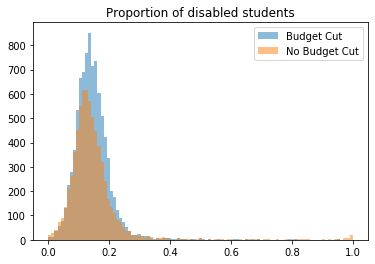

In [44]:
bins = np.linspace(0, 1, 100)
plt.hist(disability.loc[disability['LEAID'].isin(cut_rev['LEAID']), 'Proportion'], bins, alpha=0.5, label='Budget Cut')
plt.hist(disability.loc[~disability['LEAID'].isin(cut_rev['LEAID']), 'Proportion'], bins, alpha=0.5, label='No Budget Cut')
plt.legend(loc='upper right')
plt.title('Proportion of disabled students')
plt.show();

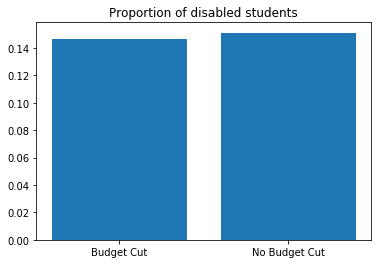

In [29]:
plt.bar(disb_prop['index'],disb_prop[0])
plt.title('Proportion of disabled students');

The budget cut is slightly higher in the school districts with low proportion of disabled students. But, the distributions still look similar and the hidden bias is not very significant.

## Problem 4

I chose to critique Tian Sang's HW3 solution for this problem. Link - https://github.com/stiangithub/HW3

Tian's solution is to cut 15% budget from all school districts. Instead of cutting same amount from each school district, Tian suggested to cut equal proportion of funding.

Although this method seems to be unbiased, I think there is an important thing that should have also been taken into account. For schools that have expenditure greater than revenue, cutting more revenue could push them into debts. May be cutting equal proportion of funding by selecting schools that are self sustainable could solve this problem.

## Problem 5

I chose to summarize and comment on Map Reduce and Hadoop lecture by Prof. Jan Vitek. A breif overview of the history of Map Reduce and Hadoop was informative. The lecture provided a good understanding of implementation of map and reduce sub routines which was followed up by some interesting examples. I got a better understanding of the basics of how parallelization is done is big data systems to efficiently process the information. Overall, the lecture has a very nice explanation of development and working of Map Reduce and Hadoop which I find would be very helpful to dig deep into domain. 